# Spaceship Titanic 

**Goal:** Predict whether a passenger was *Transported* (binary classification) using the Spaceship Titanic dataset.

In [44]:
# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Display settings
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth', 200)
sns.set_style('whitegrid')

## 1. Load data

In [45]:
# Load dataset (train.csv & test.csv)
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

print("Train shape:", train.shape)
print("Test shape:", test.shape)
display(train.head())

Train shape: (8693, 14)
Test shape: (4277, 13)


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


## 2. Quick dataset overview

In [46]:
print('Columns:', train.columns.tolist())
print('\nInfo:')
display(train.info())
print('Missing values:\n', train.isnull().sum().sort_values(ascending=False))
print('\nTarget distribution:\n', train['Transported'].value_counts(dropna=False))

Columns: ['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Name', 'Transported']

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64

None

Missing values:
 CryoSleep       217
ShoppingMall    208
VIP             203
HomePlanet      201
Name            200
Cabin           199
VRDeck          188
FoodCourt       183
Spa             183
Destination     182
RoomService     181
Age             179
PassengerId       0
Transported       0
dtype: int64

Target distribution:
 True     4378
False    4315
Name: Transported, dtype: int64


## 3. Exploratory Data Analysis (visuals + quick insights)

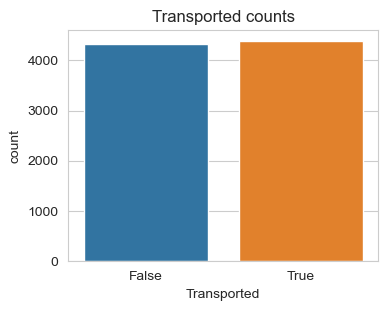

In [47]:
# Simple EDA plots
plt.figure(figsize=(4,3))
sns.countplot(x='Transported', data=train)
plt.title('Transported counts')
plt.show()

Text(0.5, 1.0, 'HomePlanet Distribution')

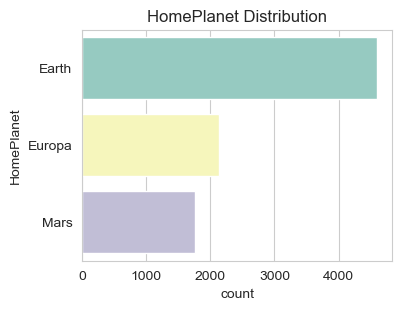

In [48]:
plt.figure(figsize=(4,3))
sns.countplot(y="HomePlanet" , palette="Set3", data=train, order = train['HomePlanet'].value_counts().index)
plt.title('HomePlanet Distribution')

Text(0.5, 1.0, 'Destination Planet Distribution')

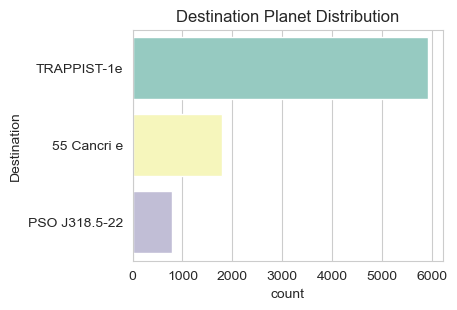

In [49]:
plt.figure(figsize=(4,3))
sns.countplot(y="Destination" , palette="Set3", data=train, order = train['Destination'].value_counts().index);
plt.title("Destination Planet Distribution")

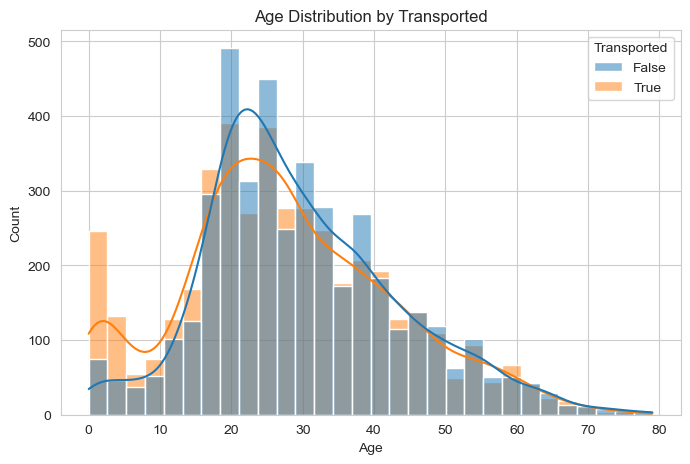

In [50]:
# Age distribution
plt.figure(figsize=(8,5))
sns.histplot(data=train, x='Age', hue='Transported', kde=True, bins=30)
plt.title('Age Distribution by Transported')
plt.show()

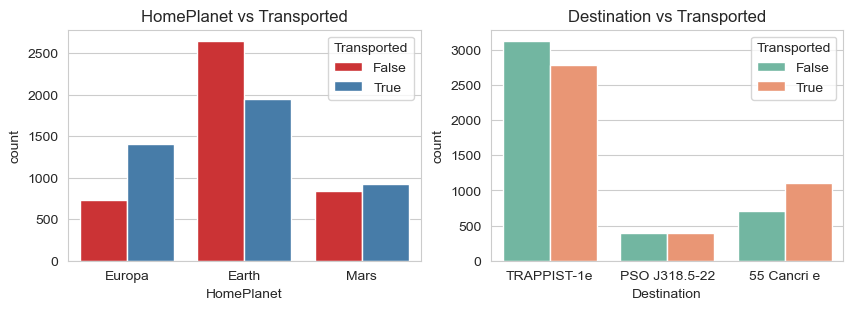

In [51]:
fig, axes = plt.subplots(1,2, figsize=(10,3))
sns.countplot(x='HomePlanet', hue='Transported', data=train, ax=axes[0], palette='Set1')
axes[0].set_title('HomePlanet vs Transported')

sns.countplot(x='Destination', hue='Transported', data=train, ax=axes[1], palette='Set2')
axes[1].set_title('Destination vs Transported')

plt.show()

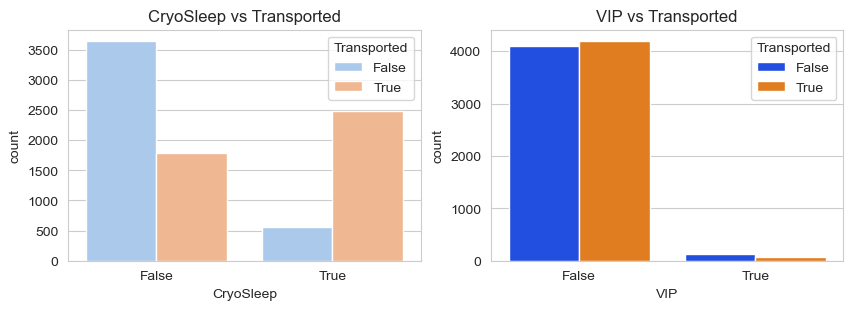

In [52]:
fig, axes = plt.subplots(1,2, figsize=(10,3))

sns.countplot(data=train, x='CryoSleep', hue='Transported', ax=axes[0], palette='pastel')
axes[0].set_title('CryoSleep vs Transported')

sns.countplot(data=train, x='VIP', hue='Transported', ax=axes[1], palette='bright')
axes[1].set_title('VIP vs Transported')

plt.show()

## 4. Preprocessing & Feature Engineering

In [53]:
# Basic feature engineering
def extract_deck(cabin):
    # Cabin format like 'B/123/P'
    try:
        return str(cabin).split("/")[0]
    except:
        return "Unknown"

def build_features(df):
    df = df.copy()
    
    # Fill missing values
    df["CryoSleep"] = df["CryoSleep"].fillna(False).astype(int)
    df["VIP"] = df["VIP"].fillna(False).astype(int)
    df["HomePlanet"] = df["HomePlanet"].fillna("Unknown")
    df["Destination"] = df["Destination"].fillna("Unknown")
    df["Cabin"] = df["Cabin"].fillna("Unknown")
    df["Age"] = df["Age"].fillna(df["Age"].median())
    
    spend_cols = ["RoomService","FoodCourt","ShoppingMall","Spa","VRDeck"]
    for col in spend_cols:
        if col in df.columns:
            df[col] = df[col].fillna(0)
    
    # Drop Name (not predictive)
    if "Name" in df.columns:
        df.drop(columns=["Name"], inplace=True)
    
    # Extract group info from PassengerId
    if "PassengerId" in df.columns:
        df["Group"] = df["PassengerId"].apply(lambda x: str(x).split("_")[0] if pd.notna(x) else x)
        df["GroupSize"] = df.groupby("Group")["PassengerId"].transform("count")
        df["IsAlone"] = (df["GroupSize"] == 1).astype(int)
    
    # Cabin deck
    df["Deck"] = df["Cabin"].apply(extract_deck)
    
    # Total spending
    df["TotalSpend"] = df[spend_cols].sum(axis=1)
    
    # Booleans as int
    for c in df.select_dtypes(include=["bool"]).columns:
        df[c] = df[c].astype(int)
    
    return df

train_fe = build_features(train)
test_fe = build_features(test)

train_fe.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Group,GroupSize,IsAlone,Deck,TotalSpend
0,0001_01,Europa,0,B/0/P,TRAPPIST-1e,39.0,0,0.0,0.0,0.0,0.0,0.0,0,0001,1,1,B,0.0
1,0002_01,Earth,0,F/0/S,TRAPPIST-1e,24.0,0,109.0,9.0,25.0,549.0,44.0,1,0002,1,1,F,736.0
2,0003_01,Europa,0,A/0/S,TRAPPIST-1e,58.0,1,43.0,3576.0,0.0,6715.0,49.0,0,0003,2,0,A,10383.0
3,0003_02,Europa,0,A/0/S,TRAPPIST-1e,33.0,0,0.0,1283.0,371.0,3329.0,193.0,0,0003,2,0,A,5176.0
4,0004_01,Earth,0,F/1/S,TRAPPIST-1e,16.0,0,303.0,70.0,151.0,565.0,2.0,1,0004,1,1,F,1091.0


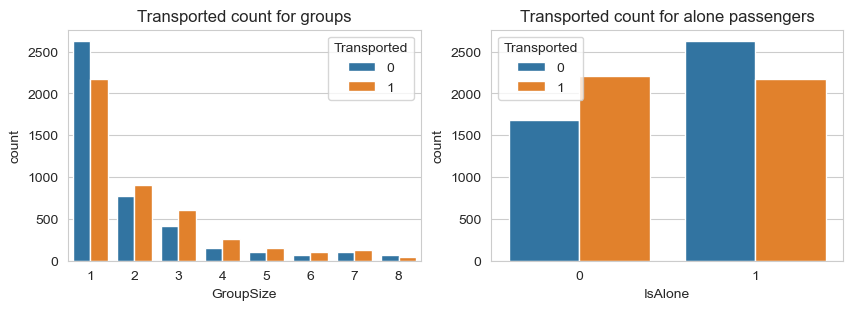

In [54]:
fig, axes = plt.subplots(1,2, figsize=(10,3))

sns.countplot(x='GroupSize', hue='Transported', data=train_fe, ax=axes[0])
axes[0].set_title("Transported count for groups")

sns.countplot(x='IsAlone', hue='Transported', data=train_fe, ax=axes[1])
axes[1].set_title("Transported count for alone passengers")

plt.show()

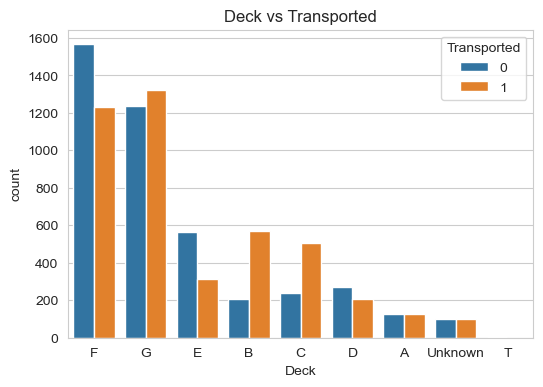

In [55]:
plt.figure(figsize=(6,4))
sns.countplot(data=train_fe, x='Deck', hue='Transported', order = train_fe['Deck'].value_counts().index)
plt.title('Deck vs Transported')
plt.show()

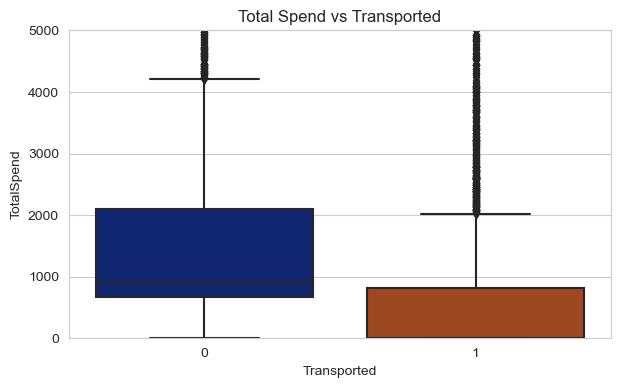

In [56]:
plt.figure(figsize=(7,4))
sns.boxplot(data=train_fe, x='Transported', y='TotalSpend', palette='dark')
plt.ylim(0, 5000)  # cap to avoid extreme outliers
plt.title('Total Spend vs Transported')
plt.show()

### Prepare X and y — simple selection of features

In [57]:
# Choose features (a mixture of engineered + raw categorical/numeric)
target = 'Transported'
drop_cols = ['PassengerId','Name','Cabin','Group'] 
features = [c for c in train_fe.columns if c not in drop_cols + [target]]

# Limit high-cardinality categoricals (for readability)
numeric_cols = train_fe[features].select_dtypes(include=["int64","float64"]).columns.tolist()
cat_cols = [c for c in features if c not in numeric_cols and train_fe[c].nunique() < 200]

print("Numeric cols:", numeric_cols)
print("Categorical cols:", cat_cols)

X = train_fe[features].copy()
y = train_fe[target].astype(int)

X.shape, y.shape

Numeric cols: ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'GroupSize', 'TotalSpend']
Categorical cols: ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'IsAlone', 'Deck']


((8693, 14), (8693,))

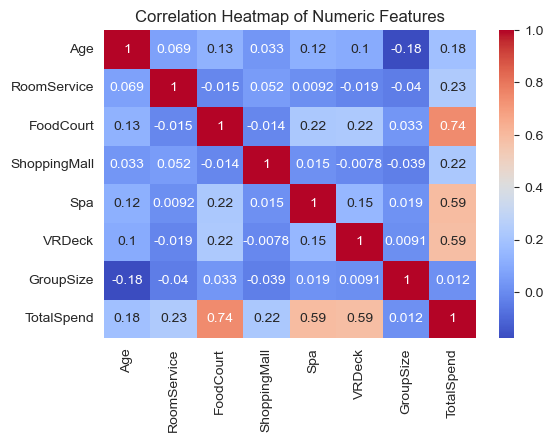

In [58]:
# Heat Map
plt.figure(figsize=(6,4))
sns.heatmap(train_fe[numeric_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Numeric Features')
plt.show()

## 5. Modeling — pipelines, cross-validation, multiple algorithms

In [59]:
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, 
                                                  stratify=y, random_state=42)

# Preprocessing
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, cat_cols)
    ])

In [60]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix, RocCurveDisplay, ConfusionMatrixDisplay

models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42),
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "SVM": SVC(probability=True, random_state=42)
}

# Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = []
for name, model in models.items():
    pipe = Pipeline(steps=[("pre", preprocessor), ("clf", model)])
    scores = cross_val_score(pipe, X, y, cv=cv, scoring="roc_auc")
    results.append({"model": name, "roc_auc_mean": scores.mean(), "roc_auc_std": scores.std()})
    print(f"{name}: ROC AUC {scores.mean():.4f} (+/- {scores.std():.4f})")
    
results_df = pd.DataFrame(results).sort_values("roc_auc_mean", ascending=False)
print("\nModel ranking:\n", results_df)

LogisticRegression: ROC AUC 0.8746 (+/- 0.0054)
RandomForest: ROC AUC 0.8643 (+/- 0.0042)
KNN: ROC AUC 0.8367 (+/- 0.0040)
SVM: ROC AUC 0.8721 (+/- 0.0071)

Model ranking:
                 model  roc_auc_mean  roc_auc_std
0  LogisticRegression      0.874600     0.005430
3                 SVM      0.872051     0.007064
1        RandomForest      0.864328     0.004243
2                 KNN      0.836736     0.003986


In [61]:
# Hyperparameter Tuning with GridSearchCV
from sklearn.model_selection import GridSearchCV

lr_pipe = Pipeline(steps=[("pre", preprocessor),
                         ("clf", LogisticRegression(max_iter=2000, random_state=42))])

param_grid = {
    "clf__C": [0.01, 0.1, 1, 10],
    "clf__penalty": ["l2"],  # (or "l1" if solver allows)
    "clf__solver": ["lbfgs", "liblinear"]
}

grid_search = GridSearchCV(
    lr_pipe, param_grid, cv=5, scoring="roc_auc", n_jobs=-1, verbose=2
)

grid_search.fit(X_train, y_train)

print("Best LR params:", grid_search.best_params_)
print("Best ROC AUC:", grid_search.best_score_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best LR params: {'clf__C': 10, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}
Best ROC AUC: 0.8739993248785085


Hyperparameter tuning is attempted for Logistic Regression, but the default configuration already gave the best performance. The tuned parameters slightly reduced the ROC AUC, so the untuned Logistic Regression is retained as the final model.

### Fit the best performing model and evaluate on validation set

Best Model: LogisticRegression

Validation Results:
Accuracy: 0.7872340425531915
ROC AUC: 0.8766885188653788
              precision    recall  f1-score   support

           0       0.79      0.78      0.78       863
           1       0.78      0.80      0.79       876

    accuracy                           0.79      1739
   macro avg       0.79      0.79      0.79      1739
weighted avg       0.79      0.79      0.79      1739



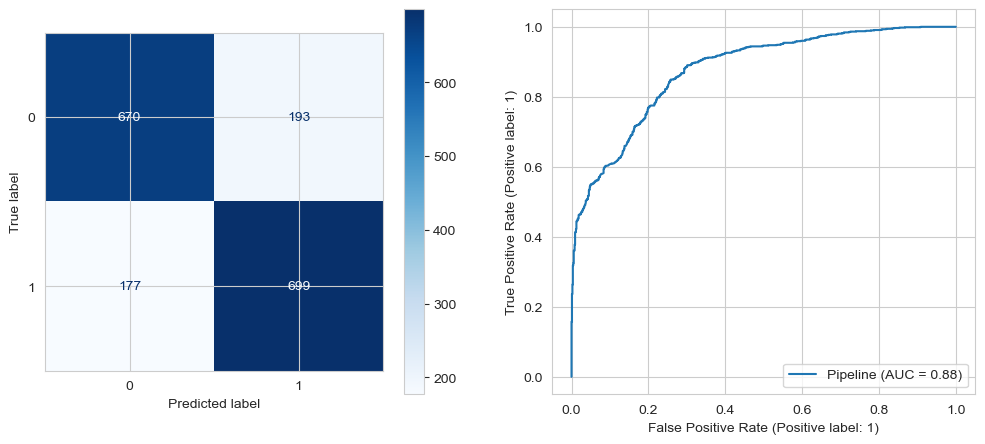

In [62]:
# Fit Best Performing Model & Evaluate on Validation Set
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, ConfusionMatrixDisplay, RocCurveDisplay

best_pipe = grid_search.best_estimator_

val_preds = best_pipe.predict(X_val)
val_proba = best_pipe.predict_proba(X_val)[:,1]

print("Best Model:", best_pipe.named_steps["clf"].__class__.__name__)
print("\nValidation Results:")
print("Accuracy:", accuracy_score(y_val, val_preds))
print("ROC AUC:", roc_auc_score(y_val, val_proba))
print(classification_report(y_val, val_preds))

# Confusion matrix & ROC curve
fig, ax = plt.subplots(1,2, figsize=(12,5))
ConfusionMatrixDisplay.from_estimator(best_pipe, X_val, y_val, ax=ax[0], cmap="Blues")
RocCurveDisplay.from_estimator(best_pipe, X_val, y_val, ax=ax[1])
plt.show()

## 6. Interpretability

Feature importance for tree-based model.

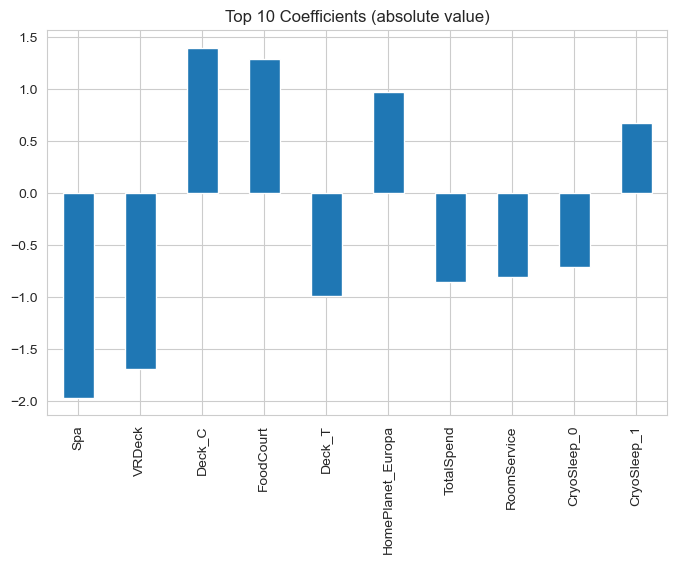

In [63]:
# Feature Importance / Coefficients

clf = best_pipe.named_steps["clf"]

if hasattr(clf, "feature_importances_"):
    # Tree-based models (RandomForest, XGB, etc.)
    num_feats = numeric_cols
    cat_feats = list(best_pipe.named_steps["pre"].named_transformers_["cat"]
                     .named_steps["ohe"].get_feature_names_out(cat_cols))
    feat_names = num_feats + cat_feats
    importances = clf.feature_importances_
    fi = pd.Series(importances, index=feat_names).sort_values(ascending=False).head(10)
    fi.plot.bar(figsize=(8,5))
    plt.title("Top 10 Feature Importances")
    plt.show()

elif hasattr(clf, "coef_"):
    # Linear models (Logistic Regression, SVM)
    num_feats = numeric_cols
    cat_feats = list(best_pipe.named_steps["pre"].named_transformers_["cat"]
                     .named_steps["ohe"].get_feature_names_out(cat_cols))
    feat_names = num_feats + cat_feats
    coefs = clf.coef_[0]
    fi = pd.Series(coefs, index=feat_names).sort_values(key=abs, ascending=False).head(10)
    fi.plot.bar(figsize=(8,5))
    plt.title("Top 10 Coefficients (absolute value)")
    plt.show()

else:
    print("This classifier does not provide feature importances or coefficients.")

## 7. Test data prediction

Submission file saved as submission.csv


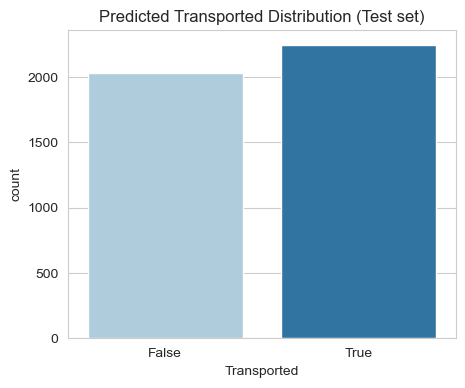

In [64]:
# Final Predictions on Test Set
X_test = test_fe[features]
test_pred = best_pipe.predict(X_test)

submission = pd.DataFrame({
    "PassengerId": test["PassengerId"],
    "Transported": test_pred.astype(bool)
})

submission.to_csv("submission.csv", index=False)
print("Submission file saved as submission.csv")

plt.figure(figsize=(5, 4))
sns.countplot(x="Transported", data=submission, palette="Paired")
plt.title("Predicted Transported Distribution (Test set)")
plt.show()